In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns

/kaggle/input/sberbank-russian-housing-market/macro.csv.zip
/kaggle/input/sberbank-russian-housing-market/train.csv.zip
/kaggle/input/sberbank-russian-housing-market/sample_submission.csv.zip
/kaggle/input/sberbank-russian-housing-market/data_dictionary.txt
/kaggle/input/sberbank-russian-housing-market/test.csv.zip


In [73]:
!unzip -o ../input/sberbank-russian-housing-market/train.csv.zip
!unzip -o ../input/sberbank-russian-housing-market/test.csv.zip 
!unzip -o ../input/sberbank-russian-housing-market/macro.csv.zip
!ls

Archive:  ../input/sberbank-russian-housing-market/train.csv.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
Archive:  ../input/sberbank-russian-housing-market/test.csv.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     
Archive:  ../input/sberbank-russian-housing-market/macro.csv.zip
  inflating: macro.csv               
__MACOSX       macro.csv     submission.csv  train.csv
catboost_info  sub_area.csv  test.csv


In [74]:
macro_df = pd.read_csv('macro.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(macro_df.shape)
print(train_df.shape)
print(test_df.shape)

(2484, 100)
(30471, 292)
(7662, 291)


In [75]:
train_df.head(100)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,2011-10-11,54,37.0,4.0,NaN,NaN,NaN,NaN,NaN,...,283,123,22,113,172,1,79,162,8,12900000
96,97,2011-10-12,30,18.0,1.0,NaN,NaN,NaN,NaN,NaN,...,20,4,1,10,11,0,1,64,7,500000
97,98,2011-10-12,39,18.0,8.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,8,28,0,7,55,13,9500000
98,99,2011-10-12,51,30.0,15.0,NaN,NaN,NaN,NaN,NaN,...,8,2,0,5,13,0,2,21,2,7100000


In [76]:
train_df['full_sq'] = np.where(train_df['full_sq']<train_df['life_sq'],train_df['life_sq'],train_df['full_sq'])
train_df.drop(train_df.index[17932], inplace=True) 
train_df['life_sq'] = np.where(train_df['life_sq']<train_df['full_sq']*0.3,train_df['full_sq']*0.5,train_df['life_sq'])
train_df['floor'] = np.where(train_df['floor']==77,7,train_df['floor'])
train_df['max_floor'] = np.where(train_df['max_floor']<train_df['floor'],train_df['floor'],train_df['max_floor'])
train_df['num_room']= np.where(train_df['num_room']>10,1,train_df['num_room'])
train_df['kitch_sq'] =  np.where(train_df['kitch_sq']>=train_df['full_sq']*0.5, train_df['full_sq']*0.3, train_df['kitch_sq'])
train_df['state'] =  np.where(train_df['state']==33, 3, train_df['state'])
#train_df['product_type'] = np.where(train_df['product_type']=='Investment',0,1)


In [77]:
#train_df['state'].unique()
#train_df['state'].describe()
#train_df[(train_df['state'])==33]
#train_df.drop(train_df.index[10089], inplace=True)
#train_df['state'] =  np.where(train_df['state']==33, 3, train_df['state'])
#train_df['state'].fillna(train_df['state'].mode().iloc[0],inplace=True)
#train_df['state'].describe()
#train_df['kitch_sq'].unique()

In [78]:

train_df['state'].unique()
#train_df[(train_df['kitch_sq'])==57]
#train_df['kitch_sq'] =  np.where(train_df['kitch_sq']>=train_df['full_sq']*0.5, train_df['full_sq']*0.3, train_df['kitch_sq'])
#train_df['kitch_sq'] =  np.where(train_df['kitch_sq']==1970, 10, train_df['kitch_sq'])

array([nan,  3.,  1.,  2.,  4.])

In [79]:
train_df.describe(include ='all')

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30470.000000,30470,30470.000000,24087.000000,30303.000000,20898.000000,20898.000000,1.686500e+04,20898.000000,20898.000000,...,30470.000000,30470.000000,30470.000000,30470.000000,30470.000000,30470.000000,30470.000000,30470.000000,30470.000000,3.047000e+04
unique,NaN,1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,15237.828881,NaN,54.585691,35.088824,7.668746,13.125754,1.827160,3.068239e+03,1.908269,5.878720,...,32.059370,10.784214,1.771841,15.046012,30.252281,0.442402,8.649097,52.797932,5.987233,7.123124e+06
std,8796.632316,NaN,57.422430,54.910314,5.304966,6.221223,1.481178,1.543924e+05,0.837039,4.117135,...,73.466587,28.386078,5.418887,29.119035,47.348528,0.609271,20.581019,46.292829,4.889216,4.780165e+06
min,1.000000,NaN,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.250000,NaN,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15237.500000,NaN,50.000000,30.000000,7.000000,14.000000,1.000000,1.979000e+03,2.000000,6.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274706e+06
75%,22855.750000,NaN,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06


In [80]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['timestamp_year'] =train_df.timestamp.dt.year
train_df['timestamp_month'] =train_df.timestamp.dt.month
train_df['timestamp_day'] =train_df.timestamp.dt.day
train_df['timestamp_year_month'] =train_df.timestamp.dt.year*100+train_df.timestamp.dt.month
train_df['timestamp_weekday'] = train_df.timestamp.dt.dayofweek

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['timestamp_year'] =test_df.timestamp.dt.year
test_df['timestamp_month'] =test_df.timestamp.dt.month
test_df['timestamp_day'] =test_df.timestamp.dt.day
test_df['timestamp_year_month'] =test_df.timestamp.dt.year*100+test_df.timestamp.dt.month
test_df['timestamp_weekday'] = train_df.timestamp.dt.dayofweek

In [81]:
train_df['timestamp_weekday'].describe()

count    30470.000000
mean         2.195143
std          1.575453
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: timestamp_weekday, dtype: float64

In [82]:
#train_df.drop(train_df.index[7457], inplace=True)

In [83]:
#train_df['product_type'] = np.where(train_df['product_type']=='Investment',0,1)
train_df['product_type'].unique()
test_df['product_type'].unique()

array(['Investment', 'OwnerOccupier', nan], dtype=object)

In [84]:
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        mean = train_df[col].mean()
        train_df[col] = train_df[col].fillna(mean)

In [85]:
#train_df['life_sq'] = np.where((train_df['life_sq'] > train_df['full_sq']), train_df['full_sq']*3/5,train_df['life_sq'])        
        
#train_df['kitch_sq'] = np.where((train_df['kitch_sq'] > train_df['life_sq']), train_df['life_sq']*1/3,train_df['kitch_sq'])        

#train_df['floor'] =  np.where(train_df['floor'].isnull(), 1, train_df['floor'])        

#train_df['max_floor'] =  np.where(train_df['max_floor'].isnull(), train_df['floor'],train_df['max_floor'])        

#train_df['material'] =  np.where(train_df['material'].isnull(), 0,train_df['material'])        

#train_df['build_year'] =  np.where(train_df['build_year'].isnull(), train_df.groupby(['sub_area'])['build_year'].transform('median'),train_df['build_year'])        

#train_df['num_room'] =  np.where(train_df['num_room'].isnull(), 1, train_df['num_room'])        


In [86]:
#train_df['price_doc_log'] = np.log(train_df['price_doc'])
#train_df['product_type'] = np.where(train_df['product_type']=='Investment',2,1)
#sub_area

In [87]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,timestamp_year,timestamp_month,timestamp_day,timestamp_year_month,timestamp_weekday
0,1,2011-08-20,43.0,27.0,4.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,1,0,52,4,5850000,2011,8,20,201108,5
1,2,2011-08-23,34.0,19.0,3.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,1,10,66,14,6000000,2011,8,23,201108,1
2,3,2011-08-27,43.0,29.0,2.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,0,4,67,10,5700000,2011,8,27,201108,5
3,4,2011-09-01,89.0,50.0,9.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,0,0,26,3,13100000,2011,9,1,201109,3
4,5,2011-09-05,77.0,77.0,4.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,2,91,195,14,16331452,2011,9,5,201109,0


In [88]:

#train_df['product_type'].unique()
train_df['product_type_num'] = np.where(train_df['product_type'].isnull(),0 ,np.where(train_df['product_type']=='Investment',1,2))
test_df['product_type_num'] = np.where(test_df['product_type'].isnull(),0 ,np.where(test_df['product_type']=='Investment',1,2))
test_df['product_type'].unique()

array(['Investment', 'OwnerOccupier', nan], dtype=object)

In [89]:

from sklearn.preprocessing import LabelEncoder

In [90]:
        lbl = LabelEncoder()
        list_joined = list(train_df['sub_area'].values) + list(test_df['sub_area'].values)
        lbl.fit(list_joined) 
        train_df['sub_area_num'] = lbl.transform(list(train_df['sub_area'].values))
        test_df['sub_area_num'] = lbl.transform(list(test_df['sub_area'].values))
       

In [91]:

train_df['sub_area_num'].unique()
output = pd.DataFrame({'id': train_df['sub_area_num'].unique(), 'sub_area': train_df['sub_area'].unique()})
output.to_csv('sub_area.csv', index=False)
output.head()

,id,sub_area
0,9,Bibirevo
1,70,Nagatinskij Zaton
2,129,Tekstil'shhiki
3,65,Mitino
4,6,Basmannoe


In [92]:
for f in train_df.columns:
    if train_df[f].dtype == 'object':
        lbl = LabelEncoder()
        list_joined = list(train_df[f].values) + list(test_df[f].values)
        lbl.fit(list_joined) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [93]:

#abracadabra
#test_df[(test_df['sub_area']) == 'Bibirevo']
#1,8,33,71,103
#30580, 30657, 30897
#train_df[(train_df['id']) == 103].sub_area  #9
test_df[(test_df['id']) == 30657].sub_area  #9
#lbl.inverse_transform(list_joined)

183    9
Name: sub_area, dtype: int64

In [94]:
train_df['sub_area'].unique()

array([  9,  70, 129,  65,   6,  73, 122,  44,  50,  45, 143, 107,  53,
        60,  52,  71,  27, 136,  40, 118,  17,  25,  82,  74,  12,  36,
       126,  32,  67, 125,  56,  15, 135,  20, 106,  43,  13, 140, 141,
        22,  75,  38, 121,  51,  34, 117, 111,  80,  78, 128,  21,  79,
       130,   5,  85,  77,  24, 133, 115,  29, 124,  23, 131,  55,  83,
        48,  37,  19, 110, 120,  33,  28,  76,  69,  10, 116, 123, 139,
       108, 112,   0, 137,   8,  49,  41,  84,   1,  30, 119,  42,  31,
        61,  18, 113,  11,  72,  16, 127,   2,  47,  46, 145,  81, 134,
        58,  14,  62,  64,  39,  57,  35,  68,  54,  59,  26, 142,   3,
       109, 144,  63, 114,   7,   4, 102,  94,  97,  86, 105,  95, 132,
       101,  87, 103,  92, 100,  98,  90, 138,  91,  96, 104,  89,  99,
        88,  66,  93])

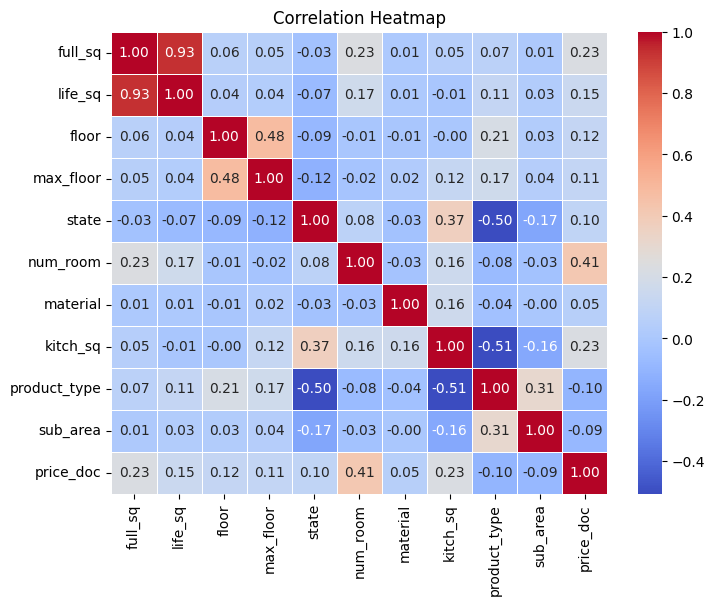

In [95]:
#correlation_matrix = train_df[['timestamp_year_month','full_sq', 'life_sq', 'floor', 'max_floor', 'state', 
#                               'material', 'build_year', 'num_room', 'kitch_sq', 'price_doc']].corr()

#correlation_matrix = train_df[['full_sq', 'life_sq', 'floor', 'max_floor', 'state'
#                               ,'num_room', 'material','kitch_sq','product_type','cafe_count_5000_price_high','cafe_count_5000_price_2500','cafe_count_2000','sport_count_3000' 
#                               ,'metro_min_avto','metro_km_avto','ttk_km','public_healthcare_km','nuclear_reactor_km'
#                               ,'sub_area','price_doc']].corr()

correlation_matrix = train_df[['full_sq', 'life_sq', 'floor', 'max_floor', 'state'
                               ,'num_room', 'material','kitch_sq','product_type'
                       #        ,'metro_min_avto','metro_km_avto','ttk_km','public_healthcare_km','nuclear_reactor_km'
                       #        ,'cafe_count_5000_price_high','cafe_count_5000_price_2500','cafe_count_2000','sport_count_3000' 
                               ,'sub_area'
                               ,'price_doc']].corr()

#correlation_matrix = train_df[['full_sq', 'life_sq','max_floor', 'material']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [96]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,sport_count_5000,market_count_5000,price_doc,timestamp_year,timestamp_month,timestamp_day,timestamp_year_month,timestamp_weekday,product_type_num,sub_area_num
0,1,2011-08-20,43.0,27.0,4.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,52,4,5850000,2011,8,20,201108,5,1,9
1,2,2011-08-23,34.0,19.0,3.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,66,14,6000000,2011,8,23,201108,1,1,70
2,3,2011-08-27,43.0,29.0,2.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,67,10,5700000,2011,8,27,201108,5,1,129
3,4,2011-09-01,89.0,50.0,9.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,26,3,13100000,2011,9,1,201109,3,1,65
4,5,2011-09-05,77.0,77.0,4.0,13.125754,1.82716,3068.239016,1.908269,5.87872,...,195,14,16331452,2011,9,5,201109,0,1,6


In [97]:
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        mean = test_df[col].mean()
        test_df[col] = test_df[col].fillna(mean)

In [98]:
#X = train_df[['timestamp','full_sq','life_sq','floor','max_floor','material','build_year','num_room']]
#X = train_df[['timestamp_year_month','full_sq','life_sq','floor','max_floor','material','build_year','num_room']]

X = train_df[['num_room','full_sq','life_sq','floor','state','max_floor', 'material','kitch_sq','product_type','ttk_km','metro_min_avto','metro_km_avto','sport_count_3000','cafe_count_5000_price_2500','cafe_count_5000_price_high','cafe_count_2000','cafe_count_3000']]
y = train_df['price_doc']
#y = train_df['price_doc_log']

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [103]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [104]:
model = ElasticNet()
model.fit(X_train, y_train)

ElasticNet()

In [105]:
model.coef_, model.intercept_

(array([1170808.58909075,  434527.46822354,   15989.42648782,
         329990.40150696,   88076.22720061,  263072.39309486,
          94218.75305052,  485641.65120056,  110297.81840361,
        -408869.19763901, -119346.91911571,  -48763.20981457,
         498117.33036933,  298340.67090172,  330040.80374642,
        -257839.68027729,  -97239.18155158]),
 7139127.483191898)

In [106]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [107]:
y_pred = model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred)
mape = mean_absolute_percentage_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred) ** 0.5
r2 = r2_score(y_train, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)
print("RMSLE:", rmsle)
print('')


MAE: 2292318.8143897206
MAPE: 0.5841362559984038
RMSE: 4087965.9014178095
R2: 0.29117691865749684
RMSLE: 0.564827089906311



In [108]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)
print("RMSLE:", rmsle)

MAE: 2230636.8121468755
MAPE: 0.5692309729600754
RMSE: 3855263.3326904983
R2: 0.29727485701048173
RMSLE: 0.5532381249381124


In [109]:
#for f in test_df.columns:
#    if test_df[f].dtype=='object':
#        lbl = LabelEncoder()
#        lbl.fit(list(test_df[f].values)) 
#        test_df[f] = lbl.transform(list(test_df[f].values))

In [110]:
#X_test = test_df[['timestamp','full_sq','life_sq','floor','max_floor','material','build_year','num_room']]
#X_test = test_df[['timestamp_year_month','full_sq','life_sq','floor','max_floor','material','build_year','num_room']]
X_test = test_df[['num_room','full_sq','life_sq','floor','state','max_floor', 'material','kitch_sq','product_type','ttk_km','metro_min_avto','metro_km_avto','sport_count_3000','cafe_count_5000_price_2500','cafe_count_5000_price_high','cafe_count_2000','cafe_count_3000']]


In [111]:
y_pred = model.predict(X_test)
#y_pred = np.exp(model.predict(X_test))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [112]:
#from sklearn.linear_model import RidgeCV

#ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
#ridge_cv.fit(X_train, y_train)
#ridge_cv_preds = ridge_cv.predict(X_test)

In [113]:
#import xgboost as xgb

#model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2)
#model_xgb.fit(X_train, y_train)
#xgb_preds = model_xgb.predict(X_test)

In [114]:
#y_pred = (ridge_cv_preds + xgb_preds) / 2

In [115]:
#output = pd.DataFrame({'id': test_df.id, 'price_doc': y_pred})
#output.to_csv('submission.csv', index=False)
#output.head()

In [116]:
data = train_df.drop(columns=['id'])
y = data['price_doc']
X = data[['num_room','full_sq','life_sq','floor','state'
          ,'max_floor', 'material','kitch_sq','product_type_num'
                  ,'ttk_km'
                  ,'metro_min_avto','metro_km_avto'
                  ,'metro_min_walk','metro_km_walk'
                  ,'public_healthcare_km','hospital_beds_raion'
                  ,'nuclear_reactor_km'
                  ,'sport_count_3000'
                  ,'cafe_count_5000_price_2500'
                  ,'cafe_count_5000_price_high'
                  ,'cafe_count_2000'
                  ,'cafe_count_3000'
                #  ,'sub_area_num'
         # ,'timestamp_year'
                 ]]

In [117]:
train_df.drop(train_df.index[7457], inplace=True)

/tmp/ipykernel_30/648537408.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, label = 'target')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_30/648537408.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For 

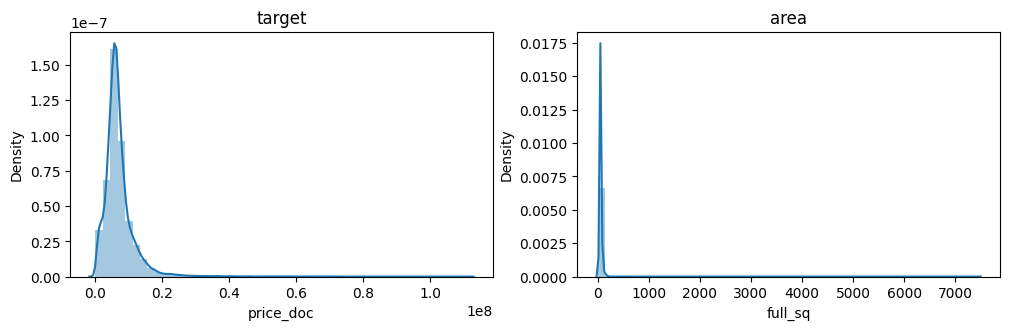

In [118]:
plt.figure(figsize =(12,7))
plt.subplot(2,2,1)
sns.distplot(y, label = 'target')
plt.title('target')

plt.subplot(2,2,2)
sns.distplot(data.full_sq, label = 'area')
plt.title('area')

#plt.subplot(2,2,3)
#sns.distplot(data.num_room, label = 'rooms')
#plt.title('rooms')

#plt.subplot(2,2,4)
#sns.distplot(data.ttk_km, label = 'metro_km_walk')
#plt.title('ttk_km')

plt.show()

In [119]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=10)
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

In [120]:
X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

/tmp/ipykernel_30/3643474163.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y), label = 'target')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_30/3643474163.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histogra

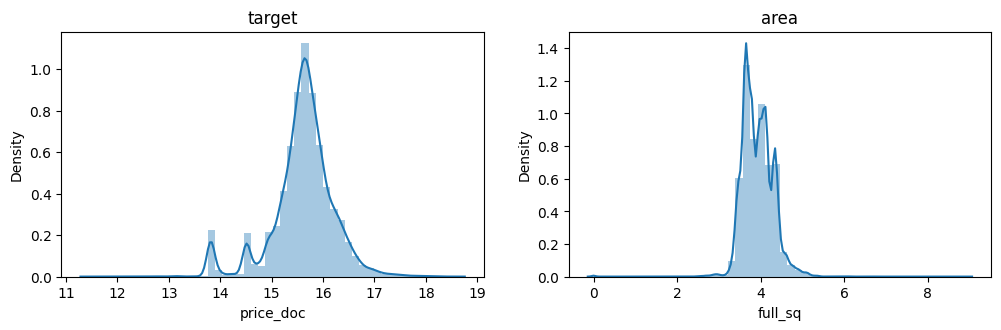

In [121]:
#sns.displot(np.log(y),label = 'target')

plt.figure(figsize =(12,7))
plt.subplot(2,2,1)
sns.distplot(np.log(y), label = 'target')
plt.title('target')

plt.subplot(2,2,2)
sns.distplot(np.log(data.full_sq), label = 'area')
plt.title('area')

plt.show()

In [122]:
X_train['full_sq'] = np.log(X_train['full_sq']+1)
X_test['full_sq'] = np.log(X_test['full_sq']+1)

In [123]:
import catboost as cb

In [124]:
train_dataset = cb.Pool(X_train, np.log(y_train)+1)
test_dataset = cb.Pool(X_test, np.log(y_test)+1)

In [125]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [126]:
grid = {'iterations': [150, 200],
        'learning_rate': [0.03, 0.05],
        'depth': [5, 7],
        'l2_leaf_reg': [1]}

model.grid_search(grid, train_dataset)

0:	learn: 16.1245373	test: 16.1186479	best: 16.1186479 (0)	total: 5.13ms	remaining: 765ms
1:	learn: 15.6418526	test: 15.6359615	best: 15.6359615 (1)	total: 9.12ms	remaining: 675ms
2:	learn: 15.1736403	test: 15.1677092	best: 15.1677092 (2)	total: 13.2ms	remaining: 647ms
3:	learn: 14.7194024	test: 14.7135944	best: 14.7135944 (3)	total: 17.2ms	remaining: 627ms
4:	learn: 14.2789130	test: 14.2731832	best: 14.2731832 (4)	total: 21ms	remaining: 609ms
5:	learn: 13.8515072	test: 13.8457753	best: 13.8457753 (5)	total: 24.7ms	remaining: 594ms
6:	learn: 13.4370108	test: 13.4314015	best: 13.4314015 (6)	total: 28.6ms	remaining: 584ms
7:	learn: 13.0349306	test: 13.0295209	best: 13.0295209 (7)	total: 32.6ms	remaining: 579ms
8:	learn: 12.6449530	test: 12.6395671	best: 12.6395671 (8)	total: 36.2ms	remaining: 568ms
9:	learn: 12.2667486	test: 12.2614160	best: 12.2614160 (9)	total: 40.3ms	remaining: 564ms
10:	learn: 11.8998447	test: 11.8946293	best: 11.8946293 (10)	total: 44.3ms	remaining: 560ms
11:	learn:

{'params': {'depth': 7,
  'learning_rate': 0.05,
  'l2_leaf_reg': 1,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [127]:
X_test = test_df[['num_room','full_sq','life_sq','floor','state'
                  ,'max_floor', 'material','kitch_sq','product_type_num'
                  ,'ttk_km'
                  ,'metro_min_avto','metro_km_avto'
                  ,'metro_min_walk','metro_km_walk'
                  ,'railroad_station_walk_min'
                  ,'public_healthcare_km','hospital_beds_raion'
                  ,'nuclear_reactor_km'
                  ,'sport_count_3000'
                  ,'cafe_count_5000_price_2500'
                  ,'cafe_count_5000_price_high'
                  ,'cafe_count_2000'
                  ,'cafe_count_3000'
               #   ,'sub_area_num'
             # ,'timestamp_year'
                 ]]

In [128]:
numeric_data = X_test.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns
X_test = X_test.fillna(numeric_data_mean)[numeric_features]
X_test['full_sq'] = np.log(X_test['full_sq']+1)
y_pred = np.exp(model.predict(X_test))-1

In [129]:
output = pd.DataFrame({'id': test_df.id, 'price_doc': y_pred})
output.to_csv('submission.csv', index=False)
output.head()

,id,price_doc
0,30474,1.363379e+07
1,30475,2.167656e+07
2,30476,1.381307e+07
3,30477,1.590738e+07
4,30478,1.405851e+07


In [130]:
train_df = pd.read_csv('train.csv')

In [131]:
train_df['product_type_num'] = np.where(train_df['product_type'].isnull(),0 ,np.where(train_df['product_type']=='Investment',1,2))
lbl = LabelEncoder()
lbl.fit(list(train_df['sub_area'].values)) 
train_df['sub_area_num'] = lbl.transform(list(train_df['sub_area'].values))

In [132]:
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        mean = train_df[col].mean()
        train_df[col] = train_df[col].fillna(mean)

In [133]:
data = train_df.drop(columns=['id'])
y = data['sub_area_num']
X = data[['num_room','full_sq','life_sq','floor','state'
          ,'max_floor', 'material','kitch_sq','product_type_num'
          ,'price_doc'
                 ]]

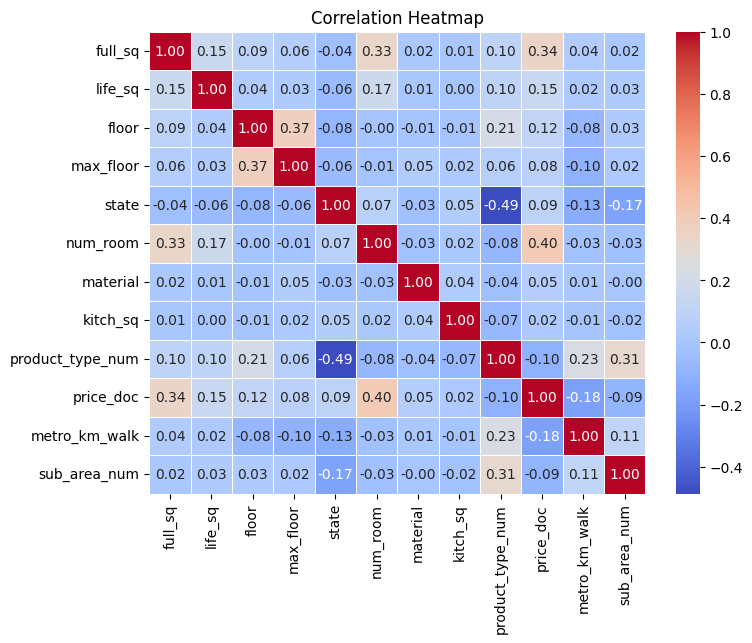

In [134]:

correlation_matrix = train_df[['full_sq', 'life_sq', 'floor', 'max_floor', 'state'
                               ,'num_room', 'material','kitch_sq','product_type_num'
                               ,'price_doc','metro_km_walk','sub_area_num']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [135]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=42)

In [136]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))


0.30708661417322836


In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
clf=DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

0.2680446194225722


In [139]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [140]:
nb_clf=GaussianNB()
nb_clf.fit(X_train,y_train)
y_pred = nb_clf.predict(X_test)
nb_clf_accuracy = accuracy_score(y_test,y_pred)

print(nb_clf_accuracy)

0.08530183727034121


In [141]:
from catboost import CatBoostClassifier

In [142]:
clf = CatBoostClassifier(iterations=150,learning_rate=0.1,depth=6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test,y_pred)

print(clf_accuracy)

0:	learn: 4.5166103	total: 747ms	remaining: 1m 51s
1:	learn: 4.3945519	total: 1.42s	remaining: 1m 44s
2:	learn: 4.2930123	total: 2.06s	remaining: 1m 40s
3:	learn: 4.2103229	total: 2.7s	remaining: 1m 38s
4:	learn: 4.1460883	total: 3.35s	remaining: 1m 37s
5:	learn: 4.0850251	total: 4s	remaining: 1m 36s
6:	learn: 4.0410284	total: 4.66s	remaining: 1m 35s
7:	learn: 3.9969151	total: 5.31s	remaining: 1m 34s
8:	learn: 3.9505095	total: 5.97s	remaining: 1m 33s
9:	learn: 3.9096961	total: 6.62s	remaining: 1m 32s
10:	learn: 3.8737241	total: 7.27s	remaining: 1m 31s
11:	learn: 3.8410504	total: 7.92s	remaining: 1m 31s
12:	learn: 3.8115941	total: 8.57s	remaining: 1m 30s
13:	learn: 3.7852840	total: 9.21s	remaining: 1m 29s
14:	learn: 3.7565137	total: 9.86s	remaining: 1m 28s
15:	learn: 3.7403437	total: 10.5s	remaining: 1m 28s
16:	learn: 3.7185745	total: 11.2s	remaining: 1m 27s
17:	learn: 3.6974271	total: 11.8s	remaining: 1m 26s
18:	learn: 3.6777112	total: 12.5s	remaining: 1m 26s
19:	learn: 3.6587535	total